In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.__version__)

True
NVIDIA RTX A6000
2.2.2


# Test prediction and visualization

In [25]:
from embryo_binary_segmentation._data_load import upload_data
from embryo_binary_segmentation._config import TEST_PARAMS
import embryo_binary_segmentation._unet_smaller as unet_smaller
from embryo_binary_segmentation._evaluation import predict_with_images, plot_loss_and_time, visualize_random_pred, iou_pytorch, score_model

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
test_path, binarize, target_size, patch_size, batch_size, load_model_path, load_csv_path = TEST_PARAMS.values()

In [28]:
eval_dataset = upload_data(test_path, 'val', binarize, patch_size, target_size)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

/home/polinasoloveva/Data/Test_visualization/FUSE
/home/polinasoloveva/Data/Test_visualization/SEG


In [29]:
len(eval_dataset)

4

In [30]:
unet_small = unet_smaller.UNet()
unet_small = unet_small.to(device)

## Plot training curves

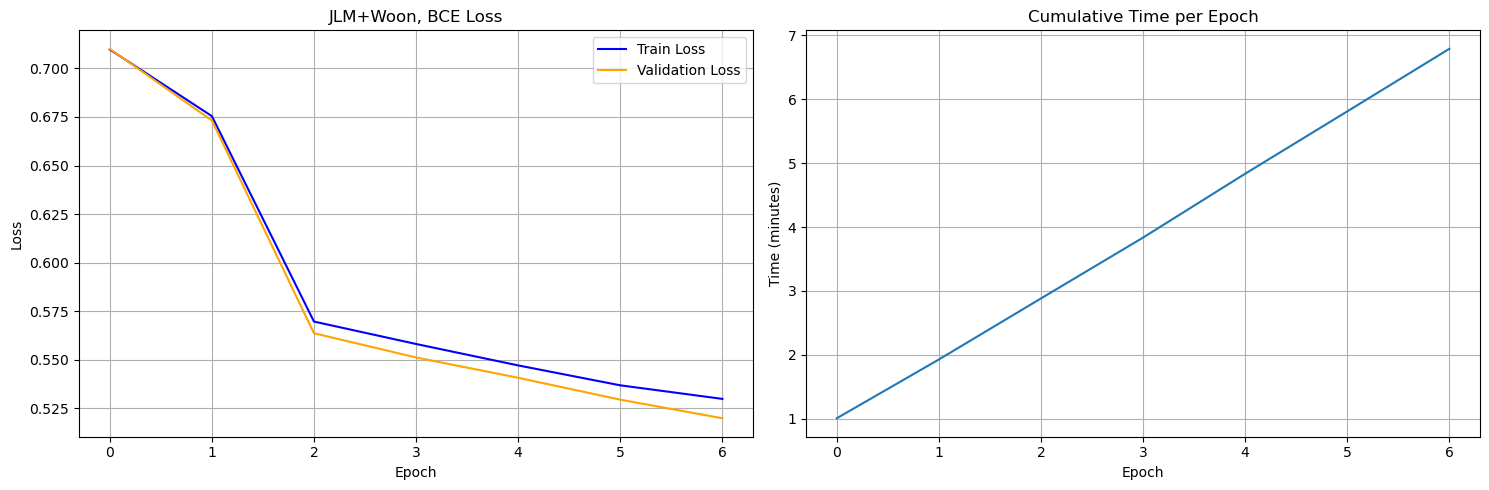

In [35]:
plot_loss_and_time(load_csv_path, 'JLM+Woon, BCE Loss')

## Made predictions

In [32]:
predictions, images_batch, masks_batch = predict_with_images(unet_small, eval_loader, load_model_path, device)
score = score_model(unet_small, load_model_path, iou_pytorch, eval_loader, device, threshold_pixel = 0.5)
print("Loaded model score: ", score, '\n')

Loaded model score:  0.5695024132728577 



## Visualize random predictions

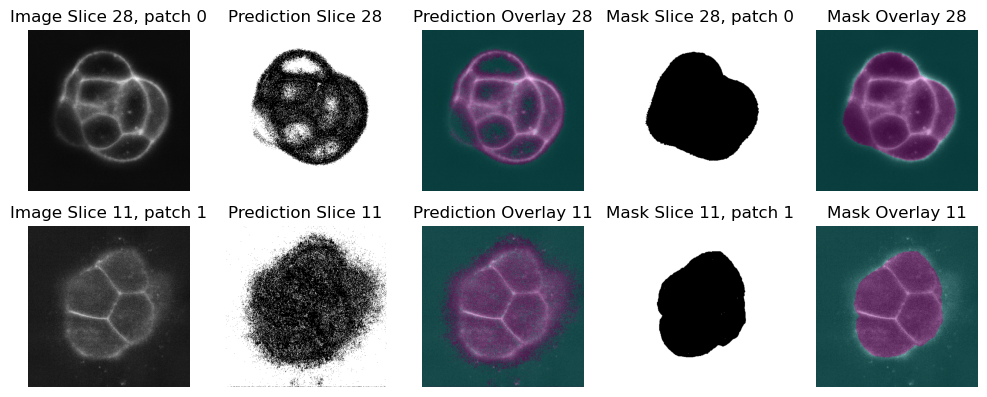

In [33]:
visualize_random_pred(images_batch, masks_batch, predictions, 4, True, threshold=0.5, alpha=0.2)

# Made and Save final predictions

In [2]:
from embryo_binary_segmentation._final_predictions import made_predictions
from embryo_binary_segmentation._config import PRED_PARAMS
import embryo_binary_segmentation._unet_smaller as unet_smaller

/home/polinasoloveva/miniforge3/envs/pytorch-env/lib/python3.10/site-packages/IO/IO.py:24: UserWarning: KLB library is not installed
  warnings.warn('KLB library is not installed')


In [3]:
pred_path, final_load_model_path, batch_size, save_pred_path = PRED_PARAMS.values()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
unet_small = unet_smaller.UNet()
unet_small = unet_small.to(device)
unet_small.load_state_dict(torch.load(final_load_model_path))

/home/polinasoloveva/miniforge3/envs/pytorch-env/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


<All keys matched successfully>

In [5]:
made_predictions(pred_path, unet_small, save_pred_path, batch_size, device)
print(f"Predictions save in {save_pred_path} \n")

/home/polinasoloveva/Data/Val/e7_woon/FUSE_raw_cropped


RuntimeError: NVML_SUCCESS == DriverAPI::get()->nvmlInit_v2_() INTERNAL ASSERT FAILED at "/opt/conda/conda-bld/pytorch_1711403380909/work/c10/cuda/CUDACachingAllocator.cpp":799, please report a bug to PyTorch. 

In [13]:
import os
import cv2 as cv
import numpy as np
import torch
from torch.utils.data import DataLoader
import IO
from tifffile import imsave

def resize_to_multiple_of_4(image):
    z, x, y = image.shape
    new_x = (x + 7) // 8 * 8
    new_y = (y + 7) // 8 * 8
    new_z = (z + 7) // 8 * 8

    padded_image = np.zeros((new_z, new_x, new_y), dtype=image.dtype)
    padded_image[:z, :x, :y] = image
    
    return padded_image, (z, x, y)


def resize_back_to_original(prediction, original_size):
    original_x, original_y, original_z = original_size
    z, x, y = prediction.shape

    unpadded_prediction = prediction[:original_z, :original_x, :original_y]
    
    return unpadded_prediction

def load_images(base_folder):
    images = []
    image_filenames = []
    original_sizes = []

    def recursive_search(folder):
        for item in os.listdir(folder):
            item_path = os.path.join(folder, item)
            
            if os.path.isdir(item_path):
                if item.startswith('FUSE'):
                    filenames = sorted(os.listdir(item_path))
                    print(item_path)
                    for filename in filenames:
                        image = IO.imread(os.path.join(item_path, filename))
                        image = np.transpose(image, (2, 0, 1))
                        resized_image, original_size = resize_to_multiple_of_4(image)
                        images.append(resized_image)
                        image_filenames.append(filename)
                        original_sizes.append(original_size)
                recursive_search(item_path)

    recursive_search(base_folder)
    
    return images, image_filenames, original_sizes

def normalization_2(images):
    cl_images = []
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for image in images:
        z_size = image.shape[0]
        cl_image = np.array([clahe.apply(image[i]) for i in range(z_size)])
        min_val = np.min(cl_image)
        max_val = np.max(cl_image)
        cl_image = (cl_image - min_val) / (max_val - min_val)
        cl_images.append(cl_image)
    return cl_images

def generate_patches(images):
    patches = [{'image': torch.tensor(image_data.astype(np.float32), dtype=torch.float32).unsqueeze(0)} for image_data in images]
    return patches

def save_predictions(predictions, filenames, original_sizes, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for prediction, filename, original_size in zip(predictions, filenames, original_sizes):
        resized_prediction = resize_back_to_original(prediction, original_size)
        binary_prediction = (resized_prediction > 0.5).astype(np.uint8) 
        save_path = os.path.join(output_folder, f"{filename}_pred.tif")
        imsave(save_path, binary_prediction)


In [14]:
def made_predictions(base_folder, model, output_folder, batch_size, device):
    images, image_filenames, original_sizes = load_images(base_folder)
    print(images[0].shape)
    #images = normalization_2(images)
    #patches = generate_patches(images)
    #predictions_loader = DataLoader(patches, batch_size=batch_size, shuffle=False)

    # model.eval()
    # predictions = []
    # with torch.no_grad():
    #     for batch in predictions_loader:
    #         inputs = batch['image'].to(device)
    #         outputs = model(inputs)
    #         predictions.extend(outputs.cpu().numpy())

    #save_predictions(predictions, image_filenames, original_sizes, output_folder)

In [15]:
made_predictions(pred_path, unet_small, save_pred_path, batch_size, device)

/home/polinasoloveva/Data/Val/e7_woon/FUSE_raw_cropped
(144, 904, 904)
